# Assembly name prediction

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.linalg import norm
from transformers import BertTokenizer, TFBertModel, TFAutoModel
import tensorflow_addons as tfa

## Simple baseline with BERT and cosine similarity

### Pre-process data for task

In [2]:
data_path = "../data/data_02.feather"
data = pd.read_feather(data_path)

In [3]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id", 'assembly_description'])
data.head()

assembly_name                                         part_names
0          Lava Lamp 2                  [Blob3, Blob2, Blob1, Glass, Cap]
1  Sample - Headphones  [Pivot hinge, Headphone hinge, Telescope hinge...
4           Coffee Mug                                         [Mug, Lid]
5  Dave's Handsome Mug                                [Lid, Seal, Vessel]
9    Mechanical Pencil  [Eraser, Pencil Lead, Rubber Grip, Gripper Rod...

In [4]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [5]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [6]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49601


### Clean part names

In [7]:
def process_part_names(list):
    part_names = []
    for string in list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    return part_names


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)


In [8]:
data.head()

assembly_name                                         part_names  \
0          Lava Lamp 2                  [Blob3, Blob2, Blob1, Glass, Cap]   
1  Sample - Headphones  [Pivot hinge, Headphone hinge, Telescope hinge...   
4           Coffee Mug                                         [Mug, Lid]   
5  Dave's Handsome Mug                                [Lid, Seal, Vessel]   
9    Mechanical Pencil  [Eraser, Pencil Lead, Rubber Grip, Gripper Rod...   

   assembly_name_clean                                   part_names_clean  
0          lava lamp 2                     [blob, blob, blob, glass, cap]  
1    sample headphones  [pivot hinge, headphone hinge, telescope hinge...  
4           coffee mug                                         [mug, lid]  
5  dave's handsome mug                                [lid, seal, vessel]  
9    mechanical pencil  [eraser, pencil lead, rubber grip, gripper rod...

### Create sentences for BERT

In [9]:
def create_sentences(data_df, deduplicate_part_names=True):
    part_name_sentences = []
    assembly_name_sentences = []

    for index, row in data_df.iterrows():
        # if len(row['part_names_clean']) > 1:
        # build single part name sentence
        part_name_sentence = "An assembly containing the following parts: "
        if deduplicate_part_names:
            part_names = set(row['part_names_clean'])
        else:
            part_names = row['part_names_clean']
        for part_name in part_names:
            part_name_sentence +=  f"{part_name}, "
        part_name_sentence = part_name_sentence[:-2] + "."
        part_name_sentences.append(part_name_sentence)

        # build single assembly name sentence
        assembly_name_sentence = f"An assembly with the name '{row['assembly_name_clean']}'"
        assembly_name_sentences.append(assembly_name_sentence)
    return part_name_sentences, assembly_name_sentences

In [10]:
part_name_sentences, assembly_name_sentences = create_sentences(data)

In [11]:
print(len(part_name_sentences))
part_name_sentences[:10]

61601


['An assembly containing the following parts: blob, glass, cap.',
 'An assembly containing the following parts: upper band, headphone hinge, pivot hinge, telescope hinge, headphone speaker.',
 'An assembly containing the following parts: mug, lid.',
 'An assembly containing the following parts: seal, vessel, lid.',
 'An assembly containing the following parts: button release, lead gripper, eraser, gripper rod, pencil lead, rubber grip.',
 'An assembly containing the following parts: wheel, link, plate, block, peg.',
 'An assembly containing the following parts: torch holder, default, head, b18.3.5m 4 x 0.7 x 10 socket fchs 10s.',
 'An assembly containing the following parts: cap, bottle base.',
 'An assembly containing the following parts: hub, arm, pivot, symmetry of btr m, bague axe corps levier, symmetry of axes molette levier, axes molette levier, bracelet droit, btr m axe levier, entretoise axe corps levier, bouton on off, vis m rouleau, hydraulic shaft, vis r x2 00e9 x0 glage lat

In [12]:
print(len(assembly_name_sentences))
assembly_name_sentences[:10]

61601


["An assembly with the name 'lava lamp 2'",
 "An assembly with the name 'sample headphones'",
 "An assembly with the name 'coffee mug'",
 "An assembly with the name 'dave's handsome mug'",
 "An assembly with the name 'mechanical pencil'",
 "An assembly with the name 'os kinematics'",
 "An assembly with the name 'torch light for bike'",
 "An assembly with the name 'bottle'",
 "An assembly with the name 'concept vehicle'",
 "An assembly with the name 'mounting arm'"]

### Train test split

In [13]:
test_data = pd.read_csv('../data/test.csv')

In [14]:
test_strings, test_labels = create_sentences(data.loc[test_data['Unnamed: 0'].tolist()])

In [15]:
test_strings[:5]

['An assembly containing the following parts: end 2, long divider, short divider, side 1, end 1, side 2.',
 'An assembly containing the following parts: 20mm stack.',
 'An assembly containing the following parts: internalcomb, basebottomkeyotherhalf, barform, basetopkey, windholder, basebottomkeyhalf, mainbox, boxlid.',
 'An assembly containing the following parts: spacer 5x10x6.35, delrin v wheel, plate mount prt9, pneumatic con m, aluminum spacer 20mm, l 2112kk or, heater block, 147, carrage mount prt8, 143, fitting, 169, 5972k154, 148, stepper prt1, l 2112kk cage, boden lever arm, 154, shaft top prt4, motor shaft, 175, microswitch 1a 125v ac seul, 174, 172, 182, boden frame, jst 4pin, 180, 149, 176, 160, 177, 156, frame b3, pin, heatsink^e3d nozzle v, 145, frame b2, 164, wheel b1, main body, 179, v slot 20x60x500 linear rail, m3cerated nut, rail cross part, 181, nozzle 0.3mm^e3d nozzle v, aluminum spacer 6mm, heater block^e3d nozzle v, 165, 151, 184, heater, fake support, 162, 166, 

In [16]:
test_labels[:5]

["An assembly with the name 'box shell version'",
 "An assembly with the name '20mm stack'",
 "An assembly with the name 'ww sport base bar box'",
 "An assembly with the name 'circle builder'",
 "An assembly with the name '2238 375.step'"]

In [17]:
train_data = pd.read_csv('../data/train.csv')

In [18]:
train_strings, train_labels = create_sentences(data.loc[train_data['Unnamed: 0'].tolist()])

In [19]:
train_strings[:5]

['An assembly containing the following parts: 27135t32.',
 'An assembly containing the following parts: satura eext, table mass regl, porte toi 1, engin reeduc, meuble rang bureau, batiment, ergometer x, lavabo, chaise bureau, pot 1, paroie cab 1, ouverture porte lpg, plat pow, pot 4, faut sal att, atteinte poignee, porte chaudiere, cheminement, paroie bureau toilettes, batiment 210616, baignoire, \\x2\\00e9\\x0\\tag\\x2\\00e8\\x0\\re, chaudiere, armoire lpg, ouverture porte toi 1, porte bain, porte lpg, paroie cab 2, tapis kettler track 9, table mass fixe, machine laver, ouverture porte chaud, lpg, toilette, cabine salle attent, toilettes, cercle manoeuvre, sortie sec, multi fitness center, chair, porte entr\\x2\\00e9\\x0\\e, porte toilettes, pot 2, ouverture porte 2, elec coffret.',
 'An assembly containing the following parts: runlarger small insert.',
 'An assembly containing the following parts: entaniya fisheye.',
 'An assembly containing the following parts: second stage, res 08

In [20]:
train_labels[:5]

["An assembly with the name 'mh 50 assembly'",
 "An assembly with the name '20160612 local complet'",
 "An assembly with the name 'runlarger small insert'",
 "An assembly with the name 'overview one mark v'",
 "An assembly with the name 'battery case'"]

In [21]:
print(f"Length of train strings: {len(train_strings)}")
print(f"Length of train labels: {len(train_labels)}")
print(f"Length of test strings: {len(test_strings)}")
print(f"Length of test labels: {len(test_labels)}")

Length of train strings: 49280
Length of train labels: 49280
Length of test strings: 12321
Length of test labels: 12321


### Tokenize and create embeddings

In [22]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
def create_embeddings(strings, labels, tokenizer, model, max_length=128, batch_size=100, pooling='cls'):

    test_strings_embeddings_batched, test_labels_embeddings_batched = [], []
    num_batches = len(strings)//batch_size
    for batch in tqdm(range(num_batches), total=num_batches):
        test_strings_token = tokenizer(strings[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True, # TODO: check the dimensions and whether it needs to be 'max_length'
                      return_tensors='tf')

        test_labels_tokens = tokenizer(labels[batch*batch_size:(batch+1)*batch_size],
                      max_length=max_length,
                      truncation=True,
                      padding=True, # TODO: check the dimensions and whether it needs to be 'max_length'
                      return_tensors='tf')

        test_strings_embeddings = model(test_strings_token)
        test_labels_embeddings = model(test_labels_tokens)

        if pooling == 'cls':
            test_strings_embeddings = test_strings_embeddings[0][:, 0, :]
            test_labels_embeddings = test_labels_embeddings[0][:, 0, :]
        else:
            test_strings_embeddings = test_strings_embeddings[1]
            test_labels_embeddings = test_labels_embeddings[1]
        test_strings_embeddings_batched.append(test_strings_embeddings)
        test_labels_embeddings_batched.append(test_labels_embeddings)

    return test_strings_embeddings_batched, test_labels_embeddings_batched

In [24]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer, bert_model)

100%|██████████| 123/123 [01:27<00:00,  1.40it/s]


### Evaluate with cosine similarity and argmax

In [25]:
def evaluate_similarity(test_strings_embeddings_batches, test_labels_embeddings_batches):
    similarity_batches = []
    for batch_id in range(len(test_strings_embeddings_batches)):
        test_strings_embeddings = tf.nn.l2_normalize(test_strings_embeddings_batches[batch_id], 0)  # TODO: test normalization across other axis
        test_labels_embeddings = tf.nn.l2_normalize(test_labels_embeddings_batches[batch_id], 0)

        similarity = test_strings_embeddings @ tf.transpose(test_labels_embeddings)
        similarity_batches.append(similarity)

    return similarity_batches

In [26]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

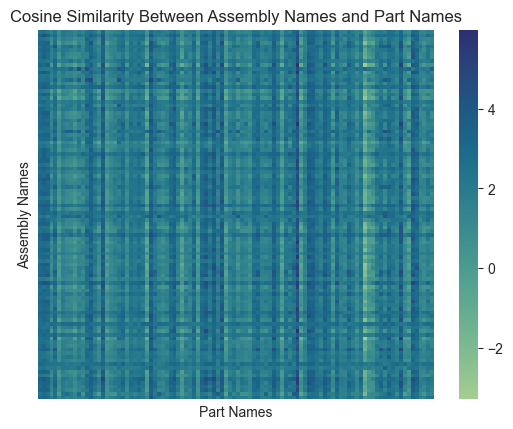

In [27]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [28]:
pred = []
true = []
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    pred.append(predicted)
    true.append(actual)
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 65 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 91 | Actual: 4
Predicted: 28 | Actual: 5
Predicted: 94 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [29]:
def evaluate_accuracy(similarity_batches):
    top_ks = [1,5,10]
    for k in top_ks:
        tot_accuracy = []
        for batch in similarity_batches:
            top_k_values = np.argsort(-batch, axis=1)[:,:k]
            correct = 0
            for index, row in enumerate(top_k_values):
                if index in row:
                    correct += 1
            accuracy = correct / len(batch)
            tot_accuracy.append(accuracy)


        print(f"Top-{k} accuracy: {np.mean(tot_accuracy)}")

In [30]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.05788617886178862
Top-5 accuracy: 0.15813008130081302
Top-10 accuracy: 0.23983739837398377


## Fine-tuned BERT

### Load fine-tuned model from checkpoint and get embeddings

In [34]:
checkpoint_dir = '../MLM/fine_tuning/bert_fine_tuned_2'
bert_tokenizer_2 = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model_2 = TFBertModel.from_pretrained(checkpoint_dir)

Some layers from the model checkpoint at ../MLM/fine_tuning/bert_fine_tuned_2 were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at ../MLM/fine_tuning/bert_fine_tuned_2 and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
test_strings_embeddings, test_labels_embeddings = create_embeddings(test_strings, test_labels, bert_tokenizer_2, bert_model_2)

100%|██████████| 123/123 [01:30<00:00,  1.36it/s]


### Evaluate

In [36]:
similarity_batches = evaluate_similarity(test_strings_embeddings, test_labels_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

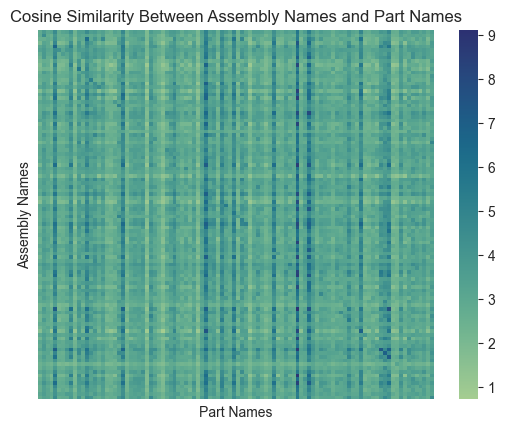

In [37]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [38]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 65 | Actual: 0
Predicted: 65 | Actual: 1
Predicted: 12 | Actual: 2
Predicted: 65 | Actual: 3
Predicted: 4 | Actual: 4
Predicted: 65 | Actual: 5
Predicted: 65 | Actual: 6
Predicted: 65 | Actual: 7
Predicted: 65 | Actual: 8
Predicted: 65 | Actual: 9


In [39]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.09447154471544716
Top-5 accuracy: 0.2099186991869919
Top-10 accuracy: 0.30349593495934957


## CLIP-like Contrastive Pre-training

### Pre-process test data and create data loader for training data
We are implementing the batched data-loader as described in [the notebook provided](https://github.com/datasci-w266/2022-fall-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb).

In [40]:
train_data_path = '../data/train.csv'

In [41]:
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [42]:
def preprocess_data(raw_data, wanted_data, tokenizer, max_length=128):
    part_name_sentences, assembly_name_sentences = create_sentences(raw_data.loc[wanted_data['Unnamed: 0'].tolist()])

    parts_tokens = tokenizer(part_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding='max_length',
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    part_input_ids = np.array(parts_tokens["input_ids"], dtype="int32")
    part_attention_masks = np.array(parts_tokens["attention_mask"], dtype="int32")
    part_token_type_ids = np.array(parts_tokens["token_type_ids"], dtype="int32")

    assemblies_tokens = tokenizer(assembly_name_sentences,
                  max_length=max_length,
                  truncation=True,
                  padding='max_length',
                  return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    assembly_input_ids = np.array(assemblies_tokens["input_ids"], dtype="int32")
    assembly_attention_masks = np.array(assemblies_tokens["attention_mask"], dtype="int32")
    assembly_token_type_ids = np.array(assemblies_tokens["token_type_ids"], dtype="int32")

    features = {
        'assembly_inputs': [part_input_ids, part_attention_masks, part_token_type_ids],
        'part_inputs': [assembly_input_ids, assembly_attention_masks, assembly_token_type_ids]
    }

    return features

In [43]:
class DataGeneratorFromFile(tf.keras.utils.Sequence):
    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=128,
                 batch_size=100,
                 shuffle=True):

        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()

    def __len__(self):
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        train_data_df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)

        batch_data = preprocess_data(
            data,
            train_data_df,
            self.tokenizer,
            self.max_length
        )

        return batch_data

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [44]:
test_data_preprocessed = preprocess_data(data, test_data, tokenizer=bert_tokenizer, max_length=128)

## Build Model

In [45]:
# Implement the text encoder
def create_text_encoder(train_layers=5, bert_model_name='bert-base-uncased', max_length=128):
    bert_model = TFAutoModel.from_pretrained(bert_model_name)

    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
        print('retrain layers: ', retrain_layers)
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)
    # pooled_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[cls_token], name='text_encoder')
    return model

In [46]:
# Implement the dual encoder
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, inputs, training=False):
        assembly_inputs, part_inputs = inputs['assembly_inputs'], inputs['part_inputs']
        assembly_embeddings = self.text_encoder(assembly_inputs, training=training)
        parts_embeddings = self.text_encoder(part_inputs, training=training)

        return assembly_embeddings, parts_embeddings

    def compute_loss(self, assembly_embeddings, parts_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(assembly_embeddings, parts_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        parts_similarity = tf.matmul(
            parts_embeddings, parts_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        assembly_similarity = tf.matmul(
            assembly_embeddings, assembly_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (parts_similarity + assembly_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        assembly_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        parts_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (assembly_loss + parts_loss) / 2

    def train_step(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        with tf.GradientTape() as tape:
            # Forward pass
            assembly_embeddings, parts_embeddings = self(inputs, training=True)
            loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, inputs):
        if isinstance(inputs, tuple):
            inputs = inputs[0]
        assembly_embeddings, parts_embeddings = self(inputs, training=False)
        loss = self.compute_loss(assembly_embeddings, parts_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [25]:
# Train the dual encoder model
num_epochs = 5  # In practice, train for at least 30 epochs

text_encoder = create_text_encoder(train_layers=1, max_length=128)
dual_encoder = DualEncoder(text_encoder, temperature=0.05)
dual_encoder.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


retrain layers:  ['_11']
freezing:  <tf.Variable 'tf_bert_model_2/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01018257, -0.06154883, -0.02649689, ..., -0.01985357,
        -0.03720997, -0.00975152],
       [-0.01170495, -0.06002603, -0.03233192, ..., -0.01681456,
        -0.04009988, -0.0106634 ],
       [-0.01975381, -0.06273633, -0.03262176, ..., -0.01650258,
        -0.04198876, -0.00323178],
       ...,
       [-0.02176224, -0.0556396 , -0.01346345, ..., -0.00432698,
        -0.0151355 , -0.02489496],
       [-0.04617237, -0.05647721, -0.00192082, ...,  0.01568751,
        -0.01387033, -0.00945213],
       [ 0.00145601, -0.08208051, -0.01597912, ..., -0.00811687,
        -0.04746607,  0.07527421]], dtype=float32)>
freezing:  <tf.Variable 'tf_bert_model_2/bert/embeddings/token_type_embeddings/embeddings:0' shape=(2, 768) dtype=float32, numpy=
array([[ 0.00043164,  0.01098826,  0.00370439, ..., -0.00661185,
        -0.00336983, -0.008

In [26]:
train_data_generator = DataGeneratorFromFile(
    tokenizer=bert_tokenizer,
    n_examples=len(pd.read_csv(train_data_path)),
    data_filename=train_data_path,
    batch_size=100
)

# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
# Create an early stopping callback.
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = dual_encoder.fit(
    train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_preprocessed,
    callbacks=[reduce_lr] # , early_stopping],
)
print("Training completed. Saving text encoder...")
text_encoder.save("text_encoder")
print("Models are saved.")

training: False
2
<class 'dict'>
{'assembly_inputs': (<tf.Tensor: shape=(100, 128), dtype=int32, numpy=
array([[ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       ...,
       [ 101, 2019, 3320, ..., 8473, 1012,  102],
       [ 101, 2019, 3320, ...,    0,    0,    0],
       [ 101, 2019, 3320, ...,    0,    0,    0]])>, <tf.Tensor: shape=(100, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, <tf.Tensor: shape=(100, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>), 'part_inputs': (<tf.Tensor: shape=(100, 128), dtype=int32, numpy=


INFO:tensorflow:Assets written to: text_encoder\assets


INFO:tensorflow:Assets written to: text_encoder\assets


Models are saved.


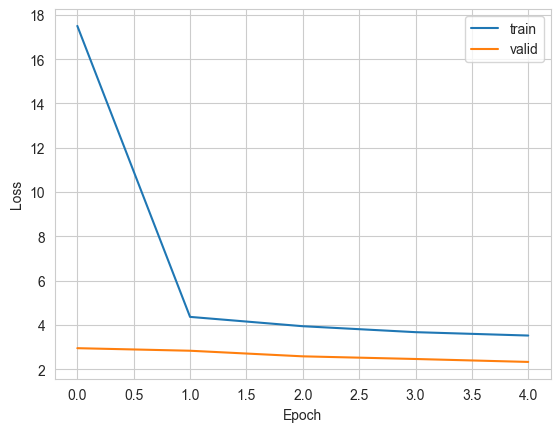

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

## Evaluate retrieval quality
To evaluate the dual encoder model, we use the captions as queries. We use the out-of-training-sample images and captions to evaluate the retrieval quality, using top k accuracy. A true prediction is counted if, for a given caption, its associated image is retrieved within the top k matches.

In [47]:
# Load text encoder
text_encoder = keras.models.load_model("text_encoder")

In [49]:
# Generate embeddings for the test data
test_part_embeddings = text_encoder.predict(test_data_preprocessed['part_inputs'])
test_assembly_embeddings = text_encoder.predict(test_data_preprocessed['assembly_inputs'])

386/386 [==============================] - 67s 175ms/step


In [50]:
# batch the embeddings into sets of 100
batch_size = 100
test_part_embeddings = np.array_split(test_part_embeddings, len(test_part_embeddings) / batch_size)
test_assembly_embeddings = np.array_split(test_assembly_embeddings, len(test_assembly_embeddings) / batch_size)

In [51]:
similarity_batches = evaluate_similarity(test_part_embeddings, test_assembly_embeddings)

[Text(0.5, 47.24444444444444, 'Part Names'),
 Text(74.44444444444444, 0.5, 'Assembly Names'),
 Text(0.5, 1.0, 'Cosine Similarity Between Assembly Names and Part Names')]

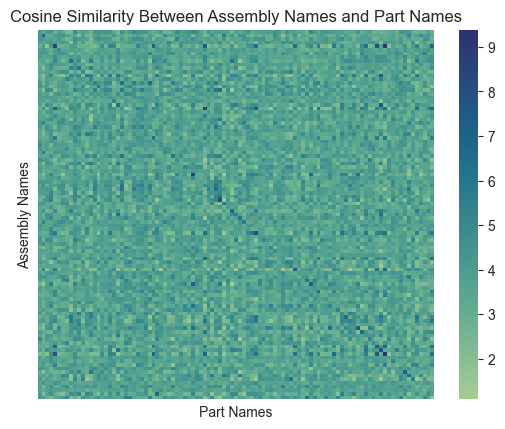

In [52]:
ax = sns.heatmap(similarity_batches[0], cmap="crest", xticklabels=False, yticklabels=False) #, annot=True)
ax.set(xlabel="Part Names", ylabel="Assembly Names", title="Cosine Similarity Between Assembly Names and Part Names")

In [53]:
for index, value in enumerate(similarity_batches[0][:10]):
    predicted = np.argmax(value)
    actual = index
    print(f"Predicted: {predicted} | Actual: {index}")

Predicted: 69 | Actual: 0
Predicted: 1 | Actual: 1
Predicted: 35 | Actual: 2
Predicted: 33 | Actual: 3
Predicted: 88 | Actual: 4
Predicted: 5 | Actual: 5
Predicted: 28 | Actual: 6
Predicted: 42 | Actual: 7
Predicted: 8 | Actual: 8
Predicted: 46 | Actual: 9


In [54]:
evaluate_accuracy(similarity_batches)

Top-1 accuracy: 0.2976293970860501
Top-5 accuracy: 0.48333574820896724
Top-10 accuracy: 0.5768220236657812
